In [26]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath("../../nnets"))
from graph import Node, Parameter, display_chain

# Read in our data, and fill missing values
data = pd.read_csv("../../data/clean_weather.csv", index_col=0)
data = data.ffill()

x = data[:10][["tmax", "tmin", "rain"]].to_numpy()
y = data[:10][["tmax_tomorrow"]].to_numpy()

In [27]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w

    def backward(self, grad):
        x, w = self.cache
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        return grad, grad

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache
        return grad * exponent * x ** (exponent - 1), 1

class Subtract(Node):
    def forward(self, x, y):
        return x - y

    def backward(self, grad):
        return grad, -grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        grad[x < 0] = 0
        return grad

In [28]:
w1 = np.random.rand(3, 3)
b1 = np.random.rand(1, 3)
w2 = np.random.rand(3,1)
b2 = np.random.rand(1, 1)

l1 = x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2

loss = (l2 - y) ** 2
loss_grad = (l2 - y) * 2

l2_w_grad = l1_activated.T @ loss_grad
l2_b_grad = loss_grad.sum(axis=0)

l1_grad = loss_grad @ w2.T
l1_grad[l1 < 0] = 0

l1_w_grad = x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

In [29]:
l1_w_grad

array([[8.18918988e+04, 5.10651759e+04, 8.62109999e+04],
       [6.31182561e+04, 3.93585312e+04, 6.64472072e+04],
       [1.11294865e+02, 6.93999279e+01, 1.17164723e+02]])

In [30]:
X = Parameter(x, desc="X", needs_grad=False)
Y = Parameter(y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

sub = Subtract(add2, Y, out="p - y")
square = Parameter(2, desc="2", needs_grad=False)
pow = Pow(sub, square, out="L")
auto_loss = pow.apply_fwd()

In [31]:
np.allclose(loss, auto_loss)

True

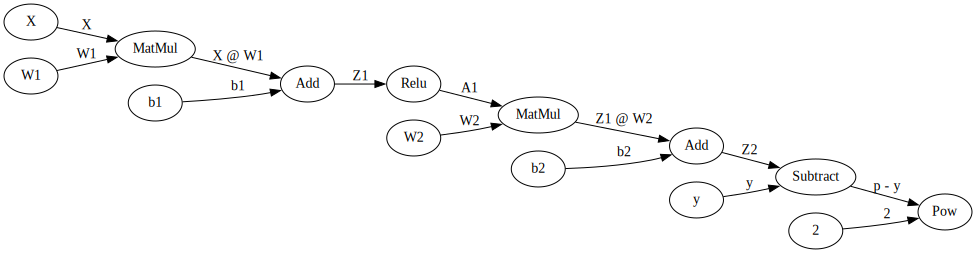

In [32]:
pow.generate_graph()

In [33]:
pow.zero_grad()
pow.apply_bwd(1)

np.allclose(l1_w_grad, w1_param.grad)

True

In [34]:
w1_param.grad

array([[8.18918988e+04, 5.10651759e+04, 8.62109999e+04],
       [6.31182561e+04, 3.93585312e+04, 6.64472072e+04],
       [1.11294865e+02, 6.93999279e+01, 1.17164723e+02]])

In [35]:
l1_w_grad

array([[8.18918988e+04, 5.10651759e+04, 8.62109999e+04],
       [6.31182561e+04, 3.93585312e+04, 6.64472072e+04],
       [1.11294865e+02, 6.93999279e+01, 1.17164723e+02]])

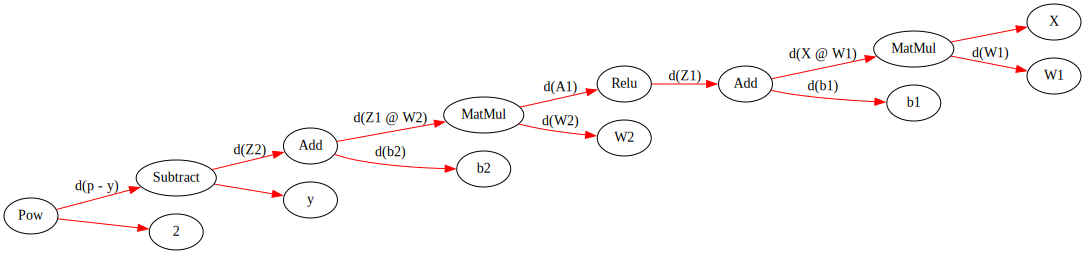

In [36]:
pow.generate_graph(backward=True)

In [37]:
pow.zero_grad()
pow.generate_derivative_chains()
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [38]:
class Exp(Node):
    def forward(self, x):
        return np.exp(x)

    def backward(self, grad):
        x = self.cache[0]
        return np.exp(x) * grad

class Max(Node):
    def forward(self, x):
        return np.max(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        max = np.max(x, axis=-1).reshape(-1,1)
        new_grad[x < max] = 0
        return new_grad

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        return np.ones_like(x) * grad

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache
        return grad * y, grad * x

In [39]:
x = np.random.rand(10, 3)
y = np.zeros_like(x)
inds = (np.arange(0,y.shape[0]), np.random.randint(0, 3, size=y.shape[0]))
y[inds] = 1

In [40]:
def calculate_staged_softmax_grad(x, y):
    max = np.max(x, axis=-1).reshape(-1,1)
    subtracted = x - max
    raised = np.exp(subtracted)
    summed = np.sum(raised, axis=-1).reshape(-1,1)
    inverted = 1 / summed
    softmax = raised * inverted

    loss_grad = -1 * y / softmax # (10,3)

    raised_grad = loss_grad * inverted # (10,3)
    inverted_grad = loss_grad * raised # (10,3)
    inverted_grad = np.sum(inverted_grad, axis=-1).reshape(-1,1) # (10,1)
    summed_grad = (-1 * summed ** -2) * inverted_grad # (10,1)
    summed_grad = np.ones_like(raised) * summed_grad # (10,3)
    raised_grad_2 = summed_grad # (10,3)
    raised_grad += raised_grad_2 # (10,3)
    x_grad = raised_grad * np.exp(subtracted)# (10,3)

    return softmax, x_grad

staged_softmax, staged_softmax_grad = calculate_staged_softmax_grad(x, y)

In [41]:
normalized_x = x - np.max(x, axis=-1).reshape(-1,1)
X = Parameter(normalized_x, desc="X", needs_grad=True)

raised = Exp(X, out="e^X")
summed = Sum(raised, out="sum(e^X)")

negative_one = Parameter(-1, desc="-1", needs_grad=False)
inverted = Pow(summed, negative_one, out="1 / sum(e^X)")
softmax = Multiply(raised, inverted, out="softmax(X)")

operations_softmax = softmax.apply_fwd()
operations_softmax

array([[0.41468226, 0.28614613, 0.29917161],
       [0.2360829 , 0.35806891, 0.40584819],
       [0.29881728, 0.44316872, 0.258014  ],
       [0.41930988, 0.26274386, 0.31794626],
       [0.36437775, 0.30170195, 0.3339203 ],
       [0.47718513, 0.25799552, 0.26481935],
       [0.39169993, 0.25427329, 0.35402679],
       [0.30839551, 0.4052374 , 0.28636709],
       [0.27545646, 0.48958513, 0.23495841],
       [0.26630375, 0.25579889, 0.47789736]])

In [42]:
np.allclose(staged_softmax, operations_softmax)

True

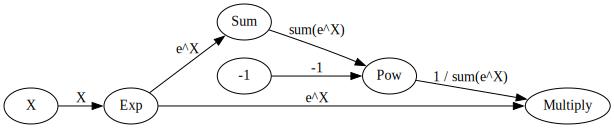

In [43]:
softmax.generate_graph()

In [44]:
loss_grad = -1 * y / operations_softmax

softmax.zero_grad()
softmax.apply_bwd(loss_grad)
operations_softmax_grad = X.grad

operations_softmax_grad

array([[ 0.41468226,  0.28614613, -0.70082839],
       [ 0.2360829 , -0.64193109,  0.40584819],
       [ 0.29881728,  0.44316872, -0.741986  ],
       [ 0.41930988, -0.73725614,  0.31794626],
       [ 0.36437775, -0.69829805,  0.3339203 ],
       [-0.52281487,  0.25799552,  0.26481935],
       [ 0.39169993,  0.25427329, -0.64597321],
       [ 0.30839551,  0.4052374 , -0.71363291],
       [ 0.27545646,  0.48958513, -0.76504159],
       [ 0.26630375, -0.74420111,  0.47789736]])

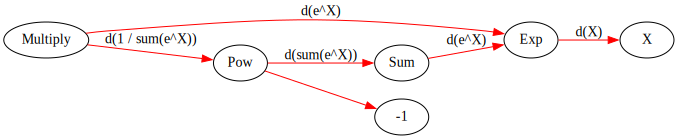

In [45]:
softmax.generate_graph(backward=True)

In [46]:
softmax.zero_grad()
softmax.generate_derivative_chains()
display_chain(X.display_partial_derivative())

<IPython.core.display.Latex object>

In [54]:
def calculate_derived_softmax_grad(softmax, loss_grad):
    output = np.zeros_like(softmax)
    for i in range(softmax.shape[0]):
        sm_row = softmax[i,:]
        sm_grad = (-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))
        row_grad = sm_grad * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

def calculate_derived_softmax(z):
    nz = z - np.max(z, axis=-1).reshape(-1,1)
    sm = np.exp(nz) / np.sum(np.exp(nz), axis=-1).reshape(-1,1)
    return sm

derived_softmax = calculate_derived_softmax(x)
np.allclose(derived_softmax, operations_softmax)

True

In [55]:
loss_grad = -1 * y / derived_softmax
derived_softmax_grad = calculate_derived_softmax_grad(derived_softmax, loss_grad)

np.allclose(derived_softmax_grad, derived_softmax - y)

True

In [56]:
np.allclose(derived_softmax_grad, operations_softmax_grad)

True

In [2]:
import numpy as np
sm_row = np.array([.25, .28, .47])

(-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))

array([[ 0.1875, -0.07  , -0.1175],
       [-0.07  ,  0.2016, -0.1316],
       [-0.1175, -0.1316,  0.2491]])